In [1]:
import sys
import os
from pathlib import Path 

# Add project root to path to allow importing src
current_dir = Path.cwd()
if current_dir.name == "notebooks":
    sys.path.append(str(current_dir.parent))
else:
    sys.path.append(str(current_dir))

from src.training import Trainer, TrainerConfig, OverSmoothingAnalyzer, SpectralAnalyzer, ReceptiveFieldAnalyzer
from src.data import GraphDataset
from src.models import GCN, GAT
from src.visualization import visualize_embeddings, node_degree_distribution, plot_confidence_distribution, test_acc_chebychev

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

c:\Users\arbio\anaconda3\envs\ml-timeseries\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42
set_seed(SEED)
print(f"Random seeds set to {SEED} for reproducibility.")

Random seeds set to 42 for reproducibility.


## 📊 Experiment 1: Data Exploration (Cora)

### 🌊 Spectral Analysis
We analyze the spectral properties of the graph Laplacian and the learned filters.

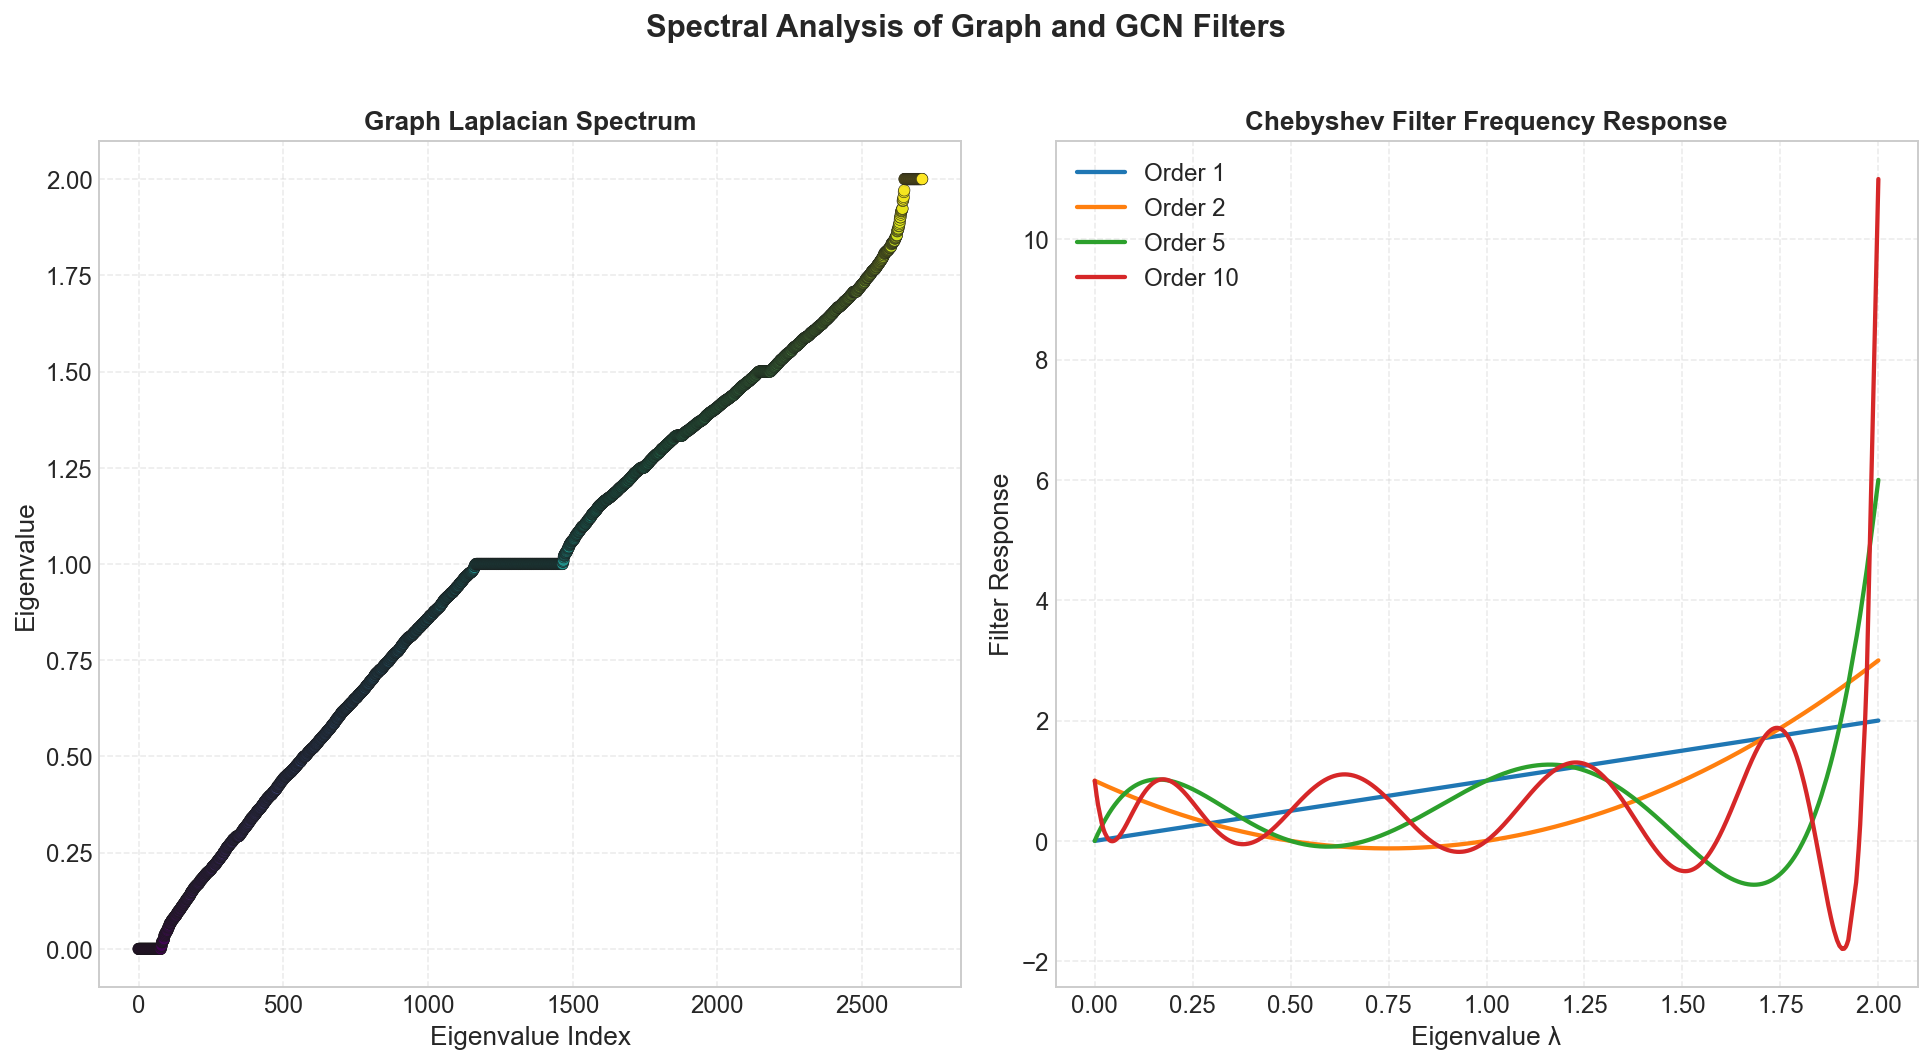

Spectral Properties:
  min_eigenvalue: -0.0000
  max_eigenvalue: 2.0000
  spectral_gap: 0.0027
  num_zero_eigenvalues: 78.0000
  algebraic_connectivity: 0.0048


In [22]:
# Load data
data_handler = DataHandler("Cora")
data = data_handler.get_data("full")

# Plot spectral analysis
fig = SpectralAnalyzer.plot_spectral_analysis(
    data["edge_index"], 
    data["x"].size(0),
    orders=[1, 2, 5, 10]
)
plt.show()

# Compute spectral gap
eigenvalues, _ = SpectralAnalyzer.compute_graph_laplacian_spectrum(data["edge_index"], data["x"].size(0))
spectral_props = SpectralAnalyzer.analyze_spectral_gap(eigenvalues)
print("Spectral Properties:")
for k, v in spectral_props.items():
    print(f"  {k}: {v:.4f}")

The Spectral Gap ($\lambda_2 - \lambda_1$) is a measure of the graph's connectivity. The larger the gap, the better the graph is connected. For Cora, the spectral gap is $2.7e-3$ indicating a disconnected graph.

### 🔍 Homophily Analysis
We analyze the homophily properties of the Cora graph to understand the correlation between node labels and their neighbors.

INFO:src.training.trainer:Initialized trainer for Cora
INFO:src.training.trainer:Model: 218382 parameters


Dataset: Cora
Node Homophily: 0.8100
Edge Homophily: 0.8100
Adjusted Homophily: 0.7684

Class-wise Homophily:
Class 0: 0.6994
Class 1: 0.7949
Class 2: 0.9058
Class 3: 0.8280
Class 4: 0.8291
Class 5: 0.7680
Class 6: 0.7690


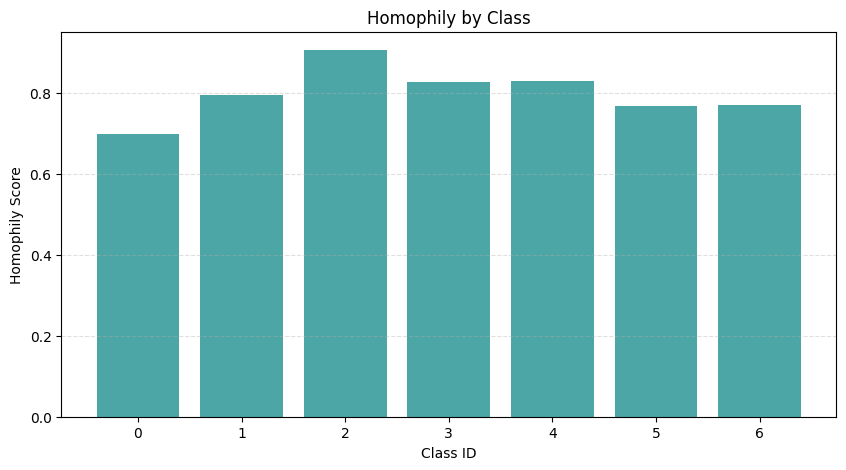

In [3]:
from src.training.analyzer import HomophilyAnalyzer

# Use the trainer's data handler to get the data
trainer = Trainer(config=TrainerConfig(dataset_name="Cora"))
data = trainer.data_handler.get_data("full")
edge_index = data["edge_index"]
labels = data["y"]

node_hom = HomophilyAnalyzer.compute_node_homophily(edge_index, labels)
edge_hom = HomophilyAnalyzer.compute_edge_homophily(edge_index, labels)
adjusted_hom = HomophilyAnalyzer.compute_adjusted_homophily(edge_index, labels)
class_hom = HomophilyAnalyzer.compute_class_homophily(edge_index, labels, num_classes=trainer.data_handler.num_classes)

print(f"Dataset: Cora")
print(f"Node Homophily: {node_hom:.4f}")
print(f"Edge Homophily: {edge_hom:.4f}")
print(f"Adjusted Homophily: {adjusted_hom:.4f}")
print("\nClass-wise Homophily:")
for c, h in class_hom.items():
    print(f"Class {c}: {h:.4f}")

# Visualize Class Homophily
plt.figure(figsize=(10, 5))
plt.bar(class_hom.keys(), class_hom.values(), color='teal', alpha=0.7)
plt.title("Homophily by Class")
plt.xlabel("Class ID")
plt.ylabel("Homophily Score")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

Cora dataset exhibits high homophily, which is expected for citation networks. This indicates that nodes with similar labels tend to be connected. GCNs tend to perform well on such datasets, as they aggregate information from neighbors, which are likely to have similar labels and thus end up with similar features.

## 📊 Experiment 2: Robust Over-Smoothing Analysis

We analyze over-smoothing using multiple metrics, including the newly added **Inter/Intra-class MAD**.

* **Mean Average Distance (MAD):** Average pairwise distance. Lower = over-smoothing.
* **Dirichlet Energy:** Measures smoothness over the graph. Lower = smoother.
* **Inter/Intra-class MAD:** Ratio of distances between different classes vs. same class. A high ratio indicates good class separability.

INFO:src.training.trainer:Initialized trainer for Cora
INFO:src.training.trainer:Model: 96846 parameters



Analyzing depth=2


Epoch 100 | Loss: 0.0000 | Val Acc: 0.7660 | LR: 3.13e-04 | Smooth: 0.000: 100%|██████████| 100/100 [00:03<00:00, 26.85it/s]
INFO:src.training.trainer:Restored best model with val_acc=0.7720


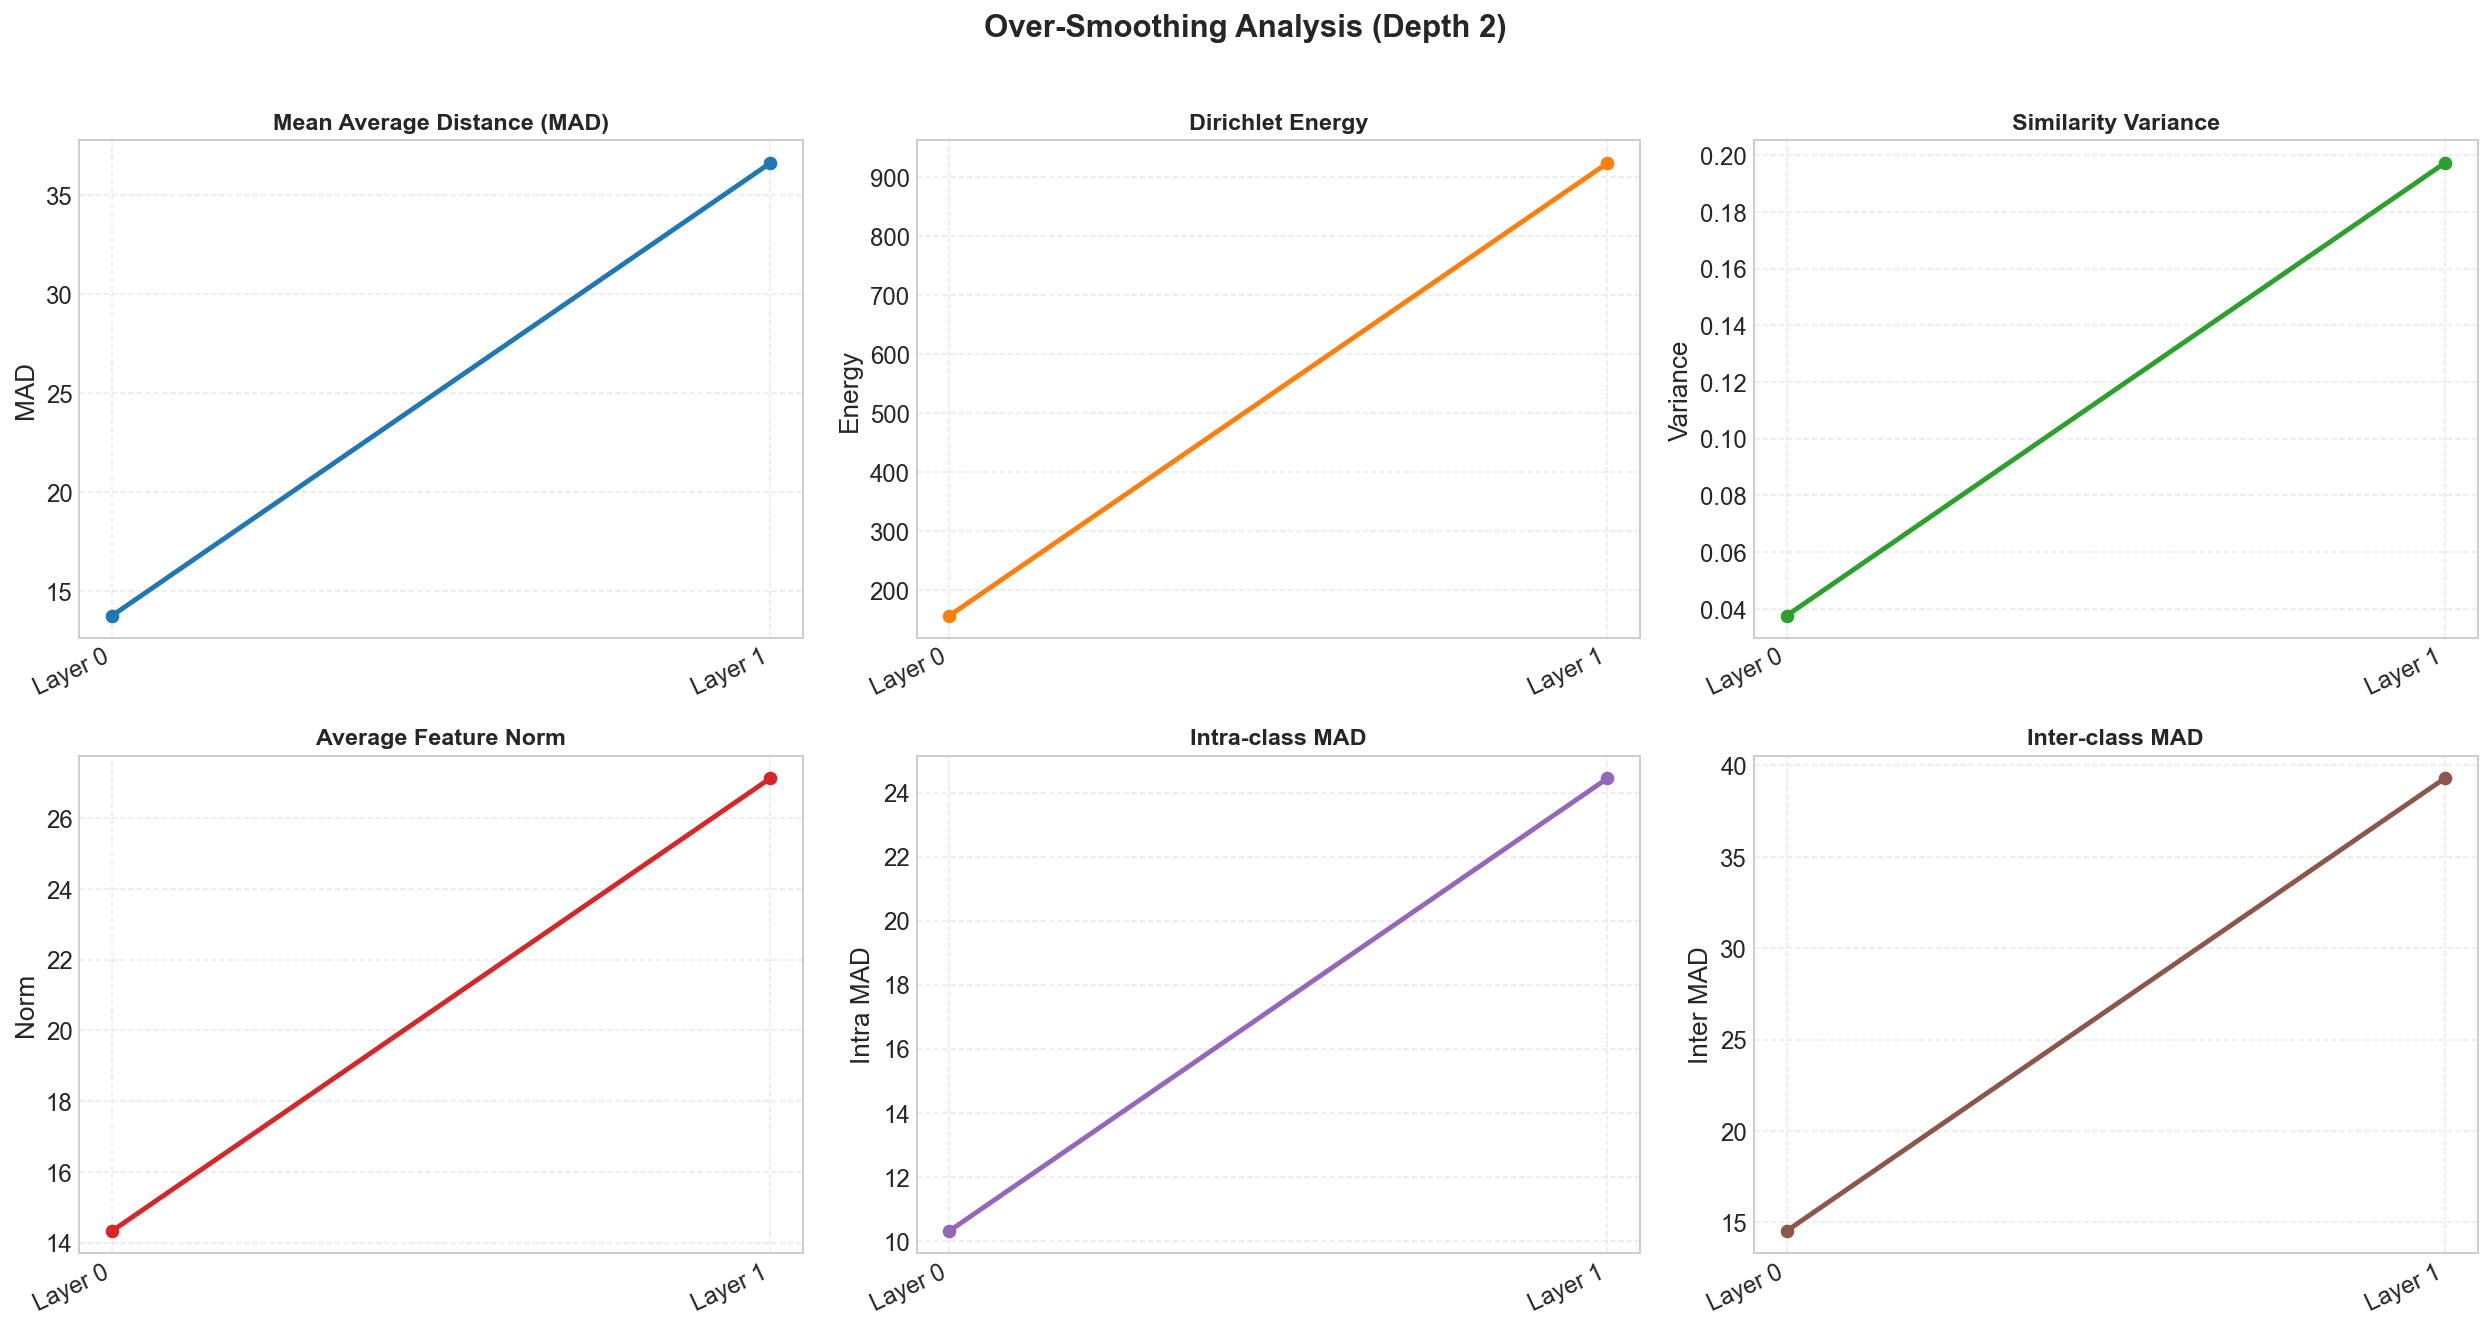

INFO:src.training.trainer:Initialized trainer for Cora
INFO:src.training.trainer:Model: 105166 parameters



Analyzing depth=4


Epoch 100 | Loss: 0.0277 | Val Acc: 0.7680 | LR: 1.56e-04 | Smooth: 0.000: 100%|██████████| 100/100 [00:06<00:00, 15.24it/s]
INFO:src.training.trainer:Restored best model with val_acc=0.7740


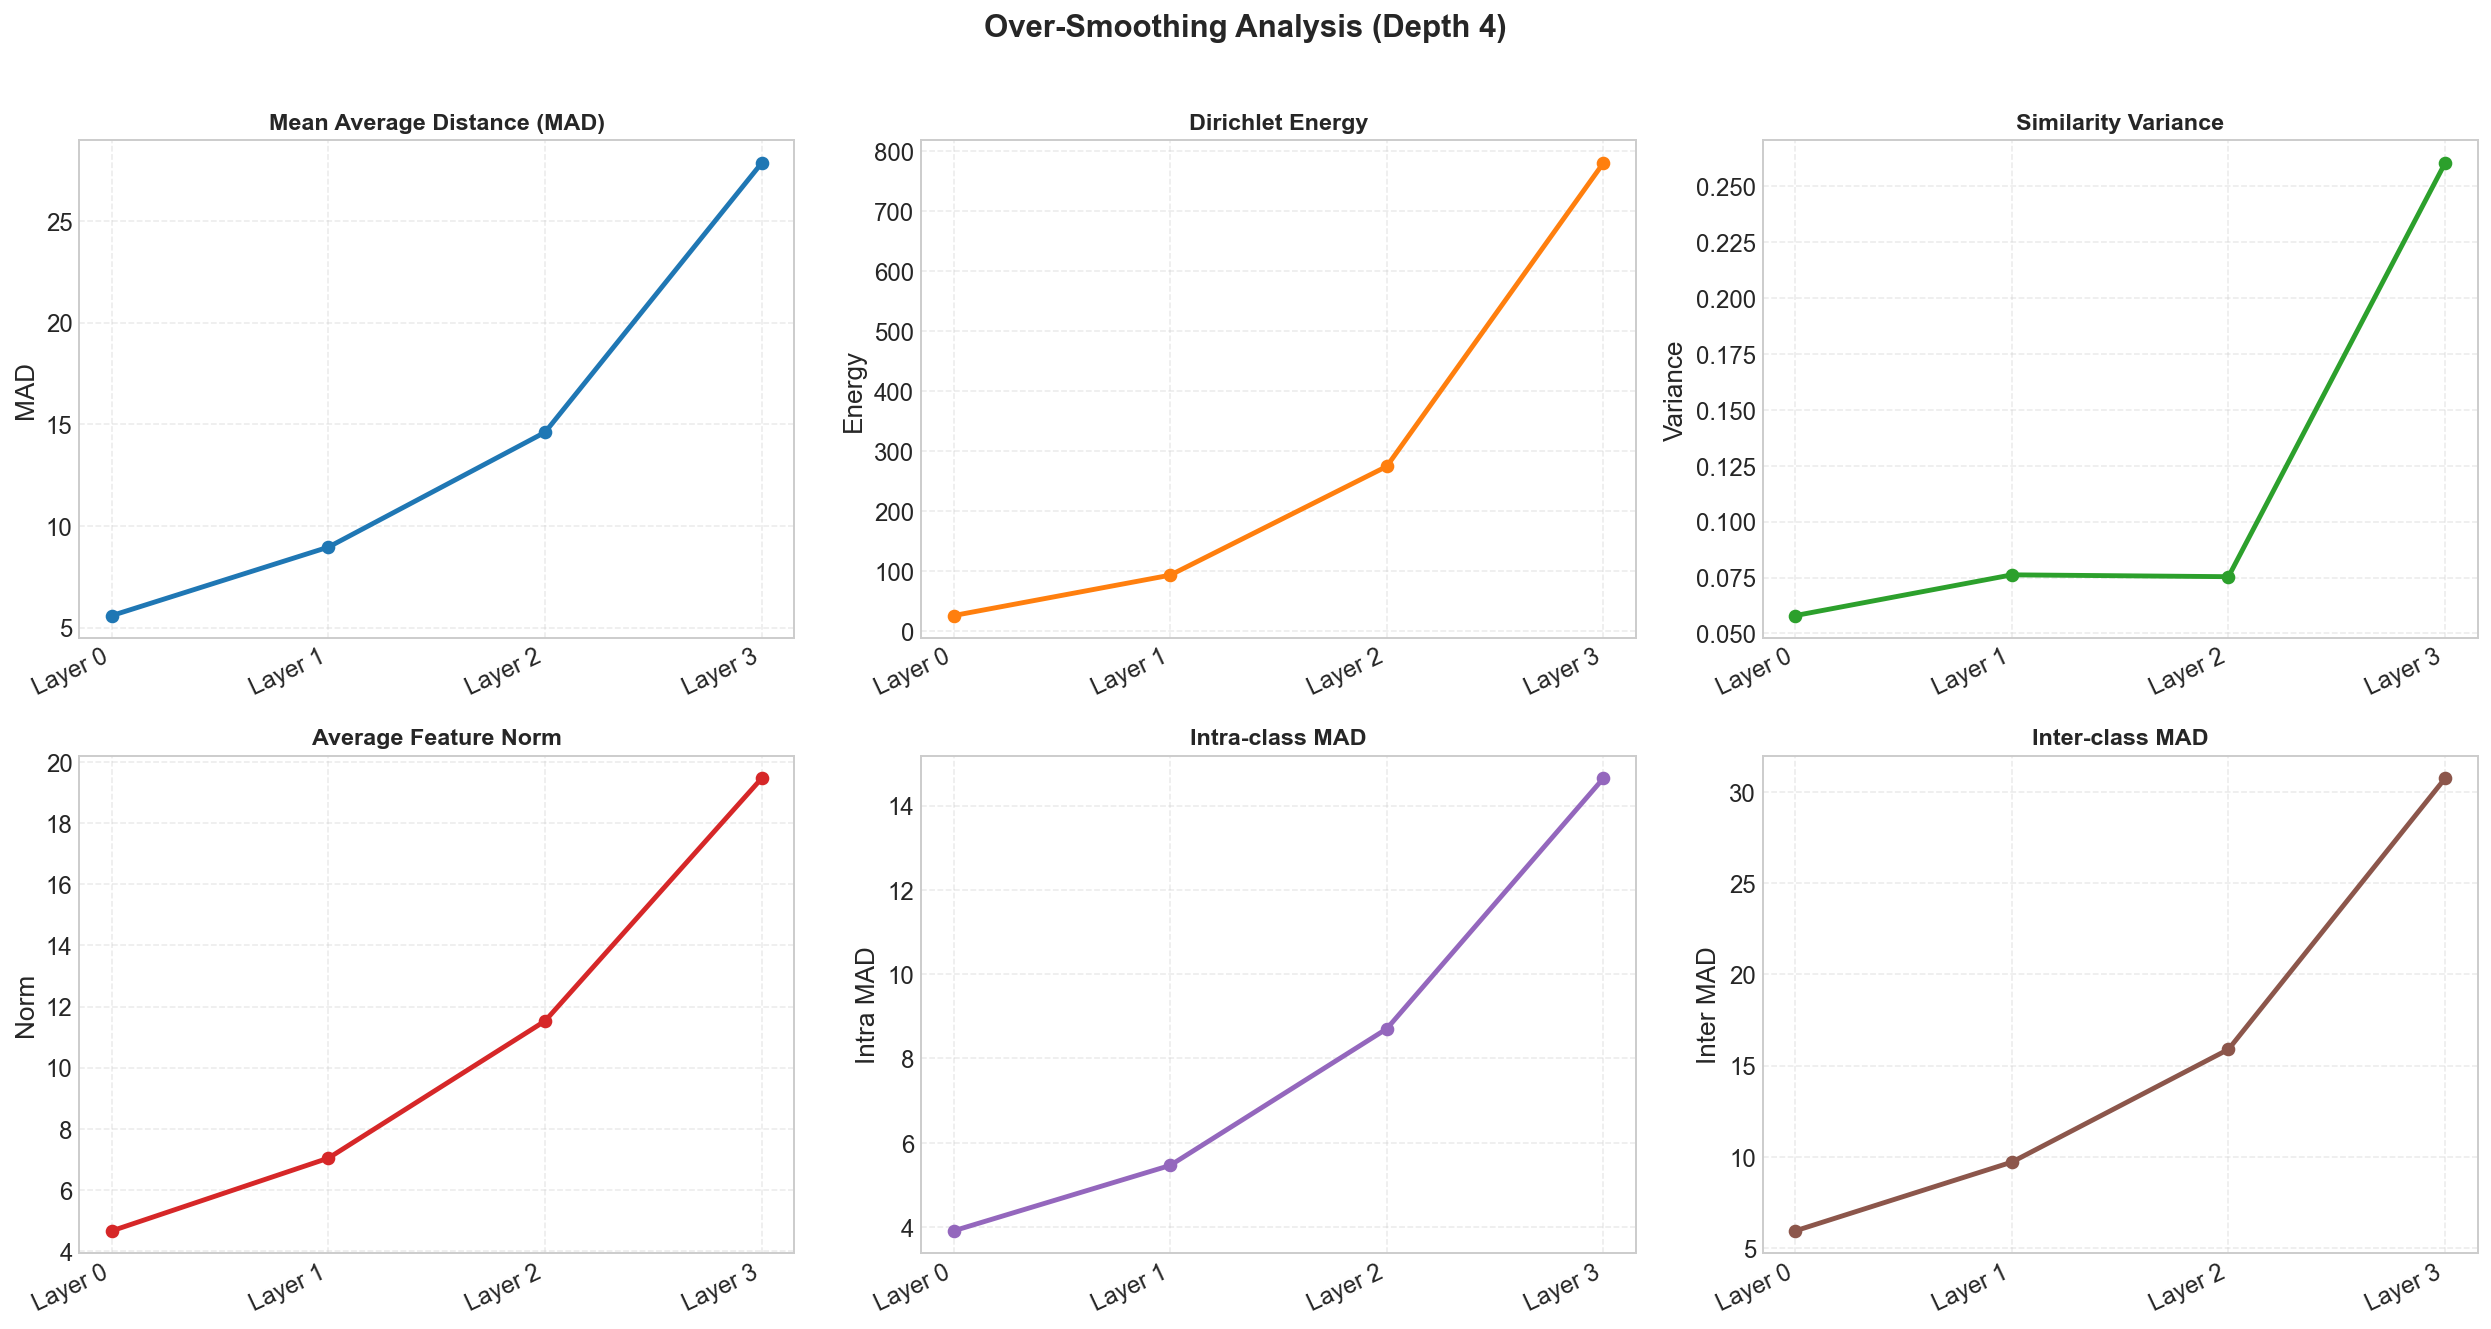

INFO:src.training.trainer:Initialized trainer for Cora
INFO:src.training.trainer:Model: 121806 parameters



Analyzing depth=8


Epoch 100 | Loss: 1.8234 | Val Acc: 0.1980 | LR: 3.91e-05 | Smooth: 0.000: 100%|██████████| 100/100 [00:12<00:00,  8.05it/s]
INFO:src.training.trainer:Restored best model with val_acc=0.2360


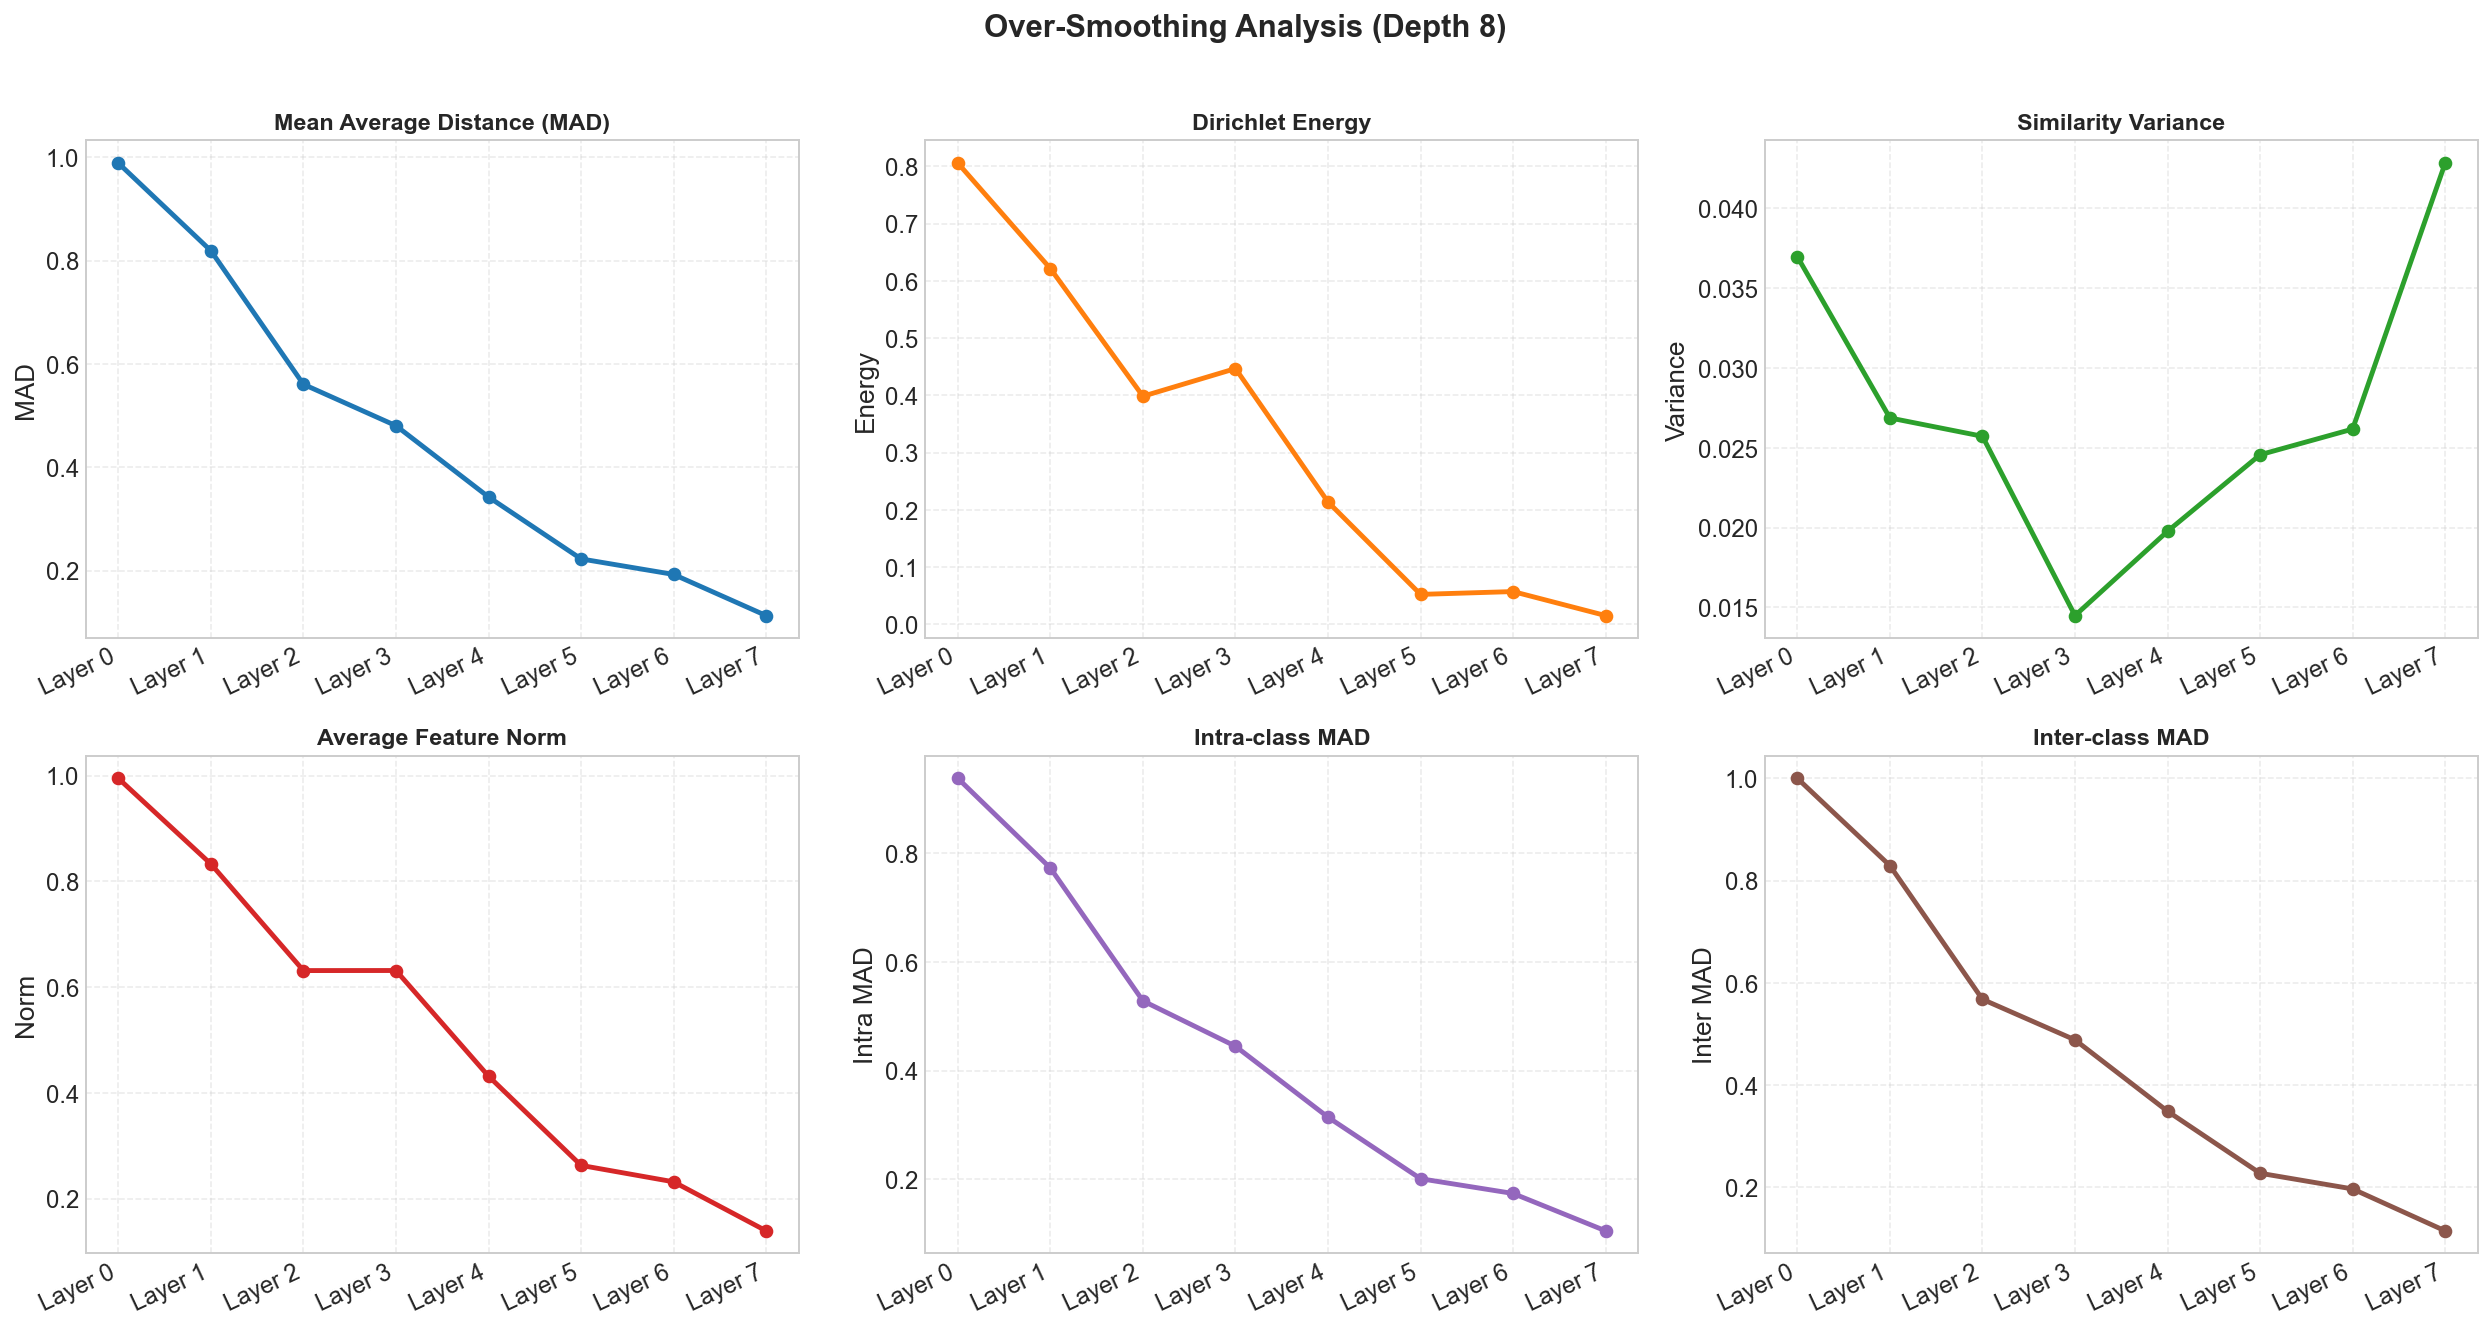

INFO:src.training.trainer:Initialized trainer for Cora
INFO:src.training.trainer:Model: 155086 parameters



Analyzing depth=16


Epoch 100 | Loss: 1.9281 | Val Acc: 0.1560 | LR: 3.91e-05 | Smooth: 0.000: 100%|██████████| 100/100 [00:26<00:00,  3.77it/s]
INFO:src.training.trainer:Restored best model with val_acc=0.3140


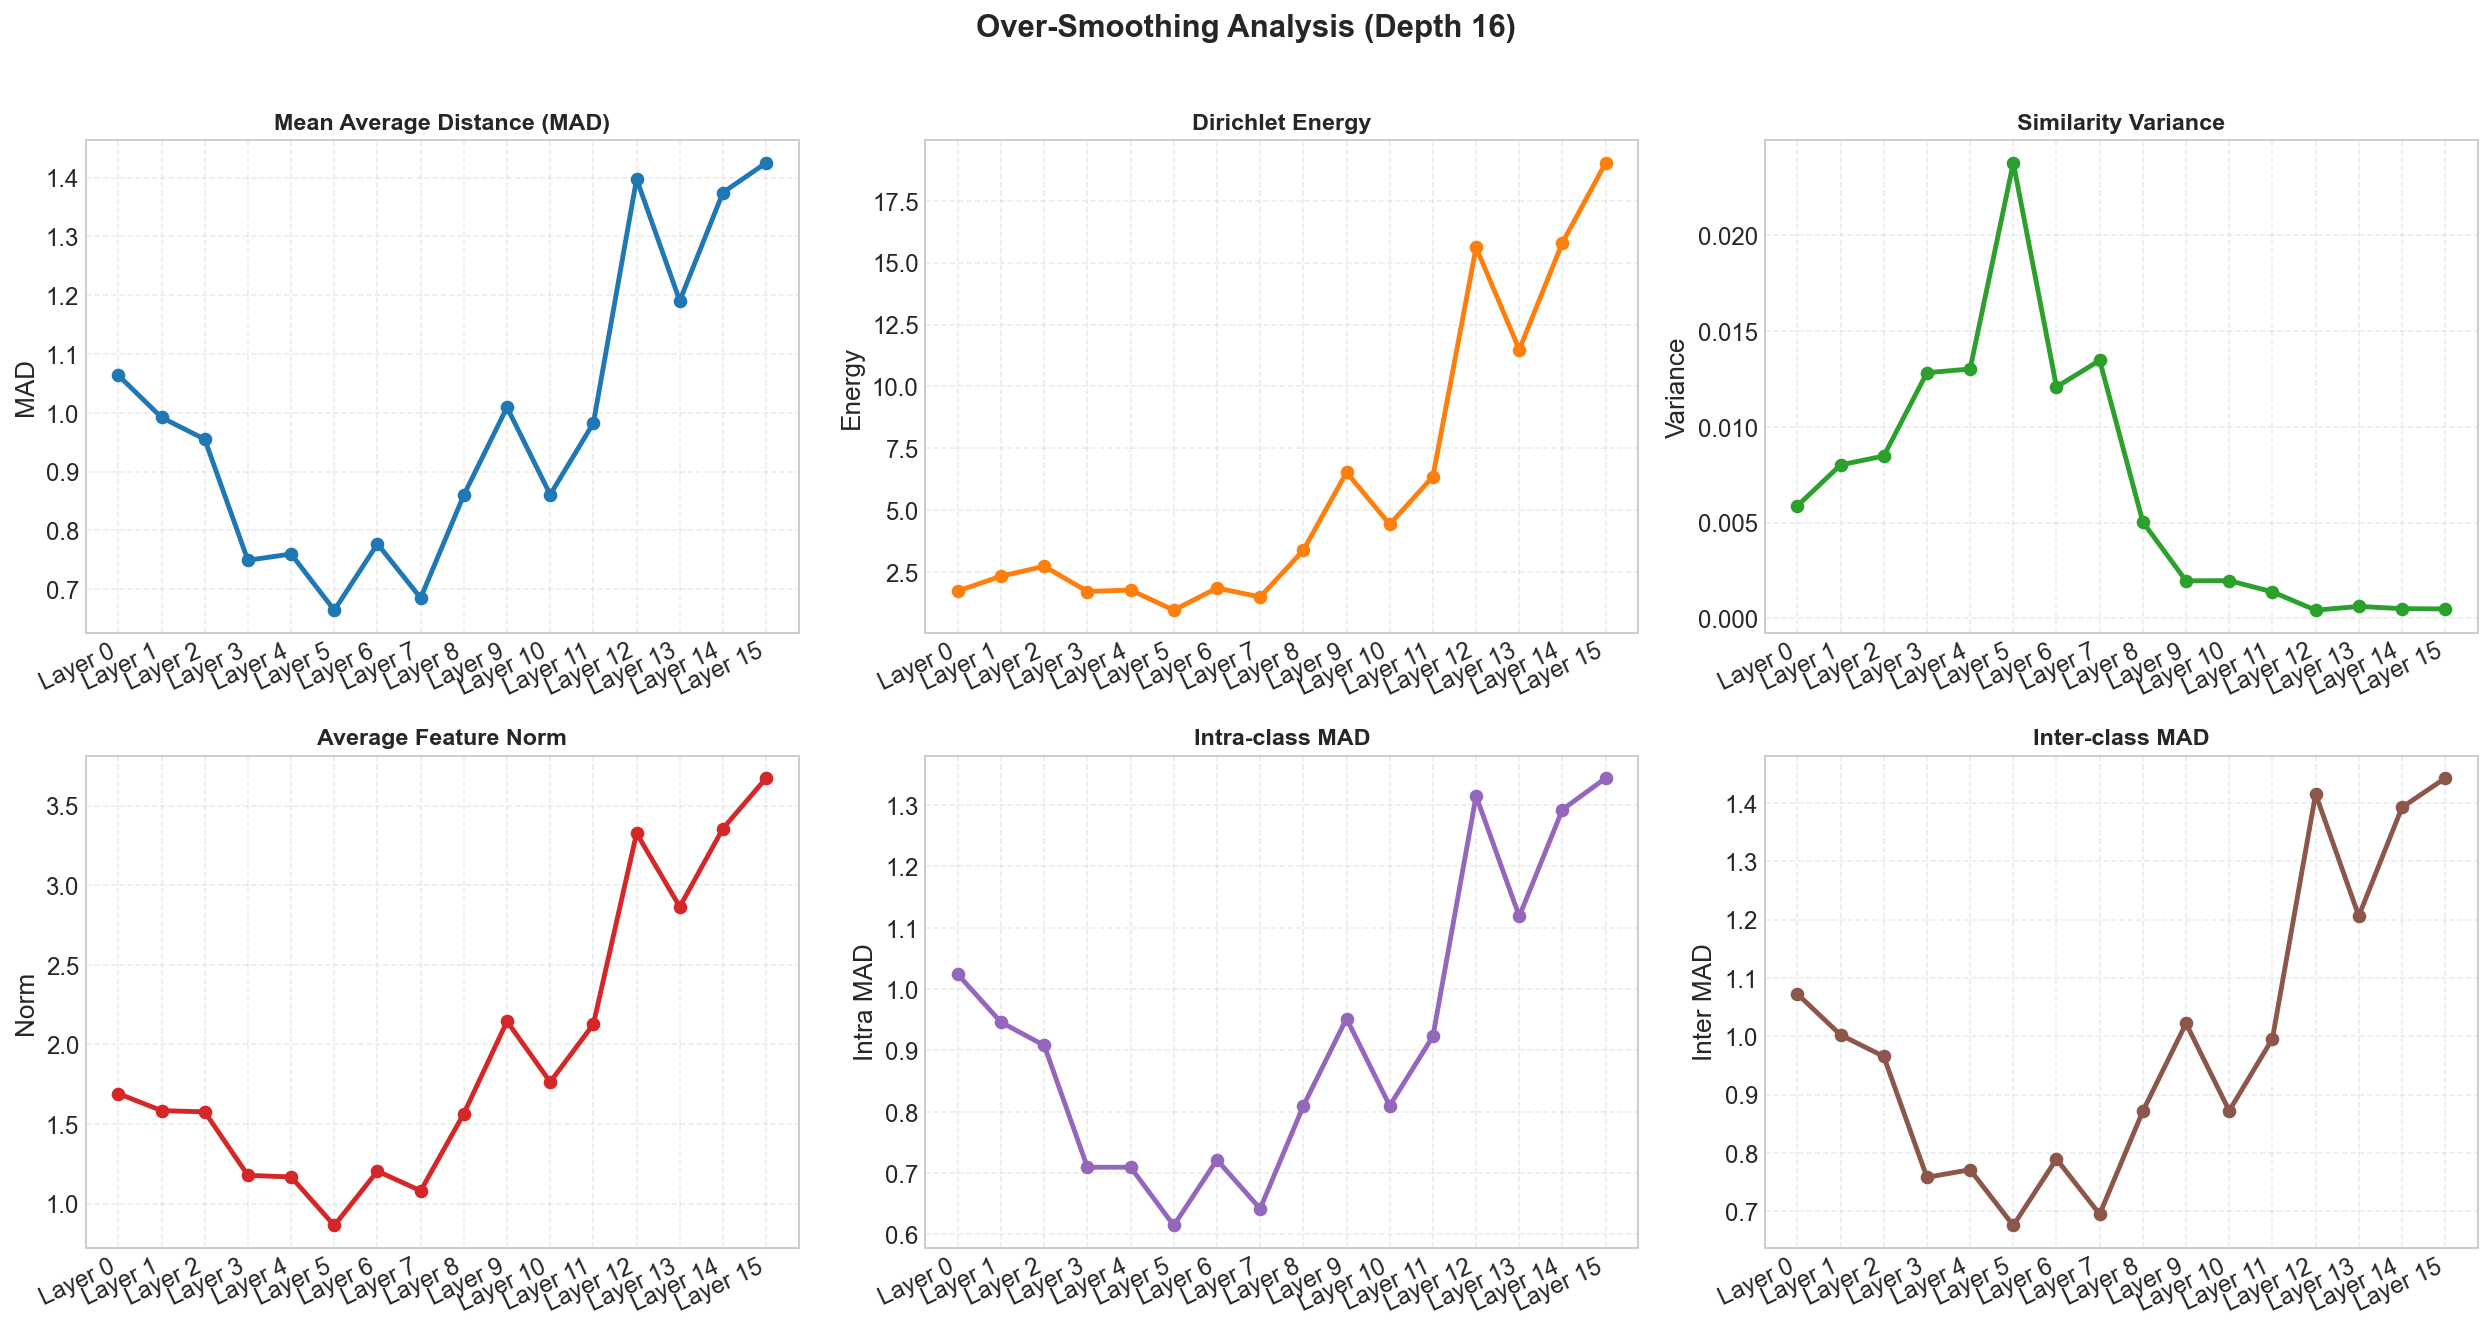

INFO:src.training.trainer:Initialized trainer for Cora
INFO:src.training.trainer:Model: 221646 parameters



Analyzing depth=32


Epoch 100 | Loss: 62.0999 | Val Acc: 0.1560 | LR: 7.81e-05 | Smooth: 0.000: 100%|██████████| 100/100 [00:51<00:00,  1.96it/s]
INFO:src.training.trainer:Restored best model with val_acc=0.2180


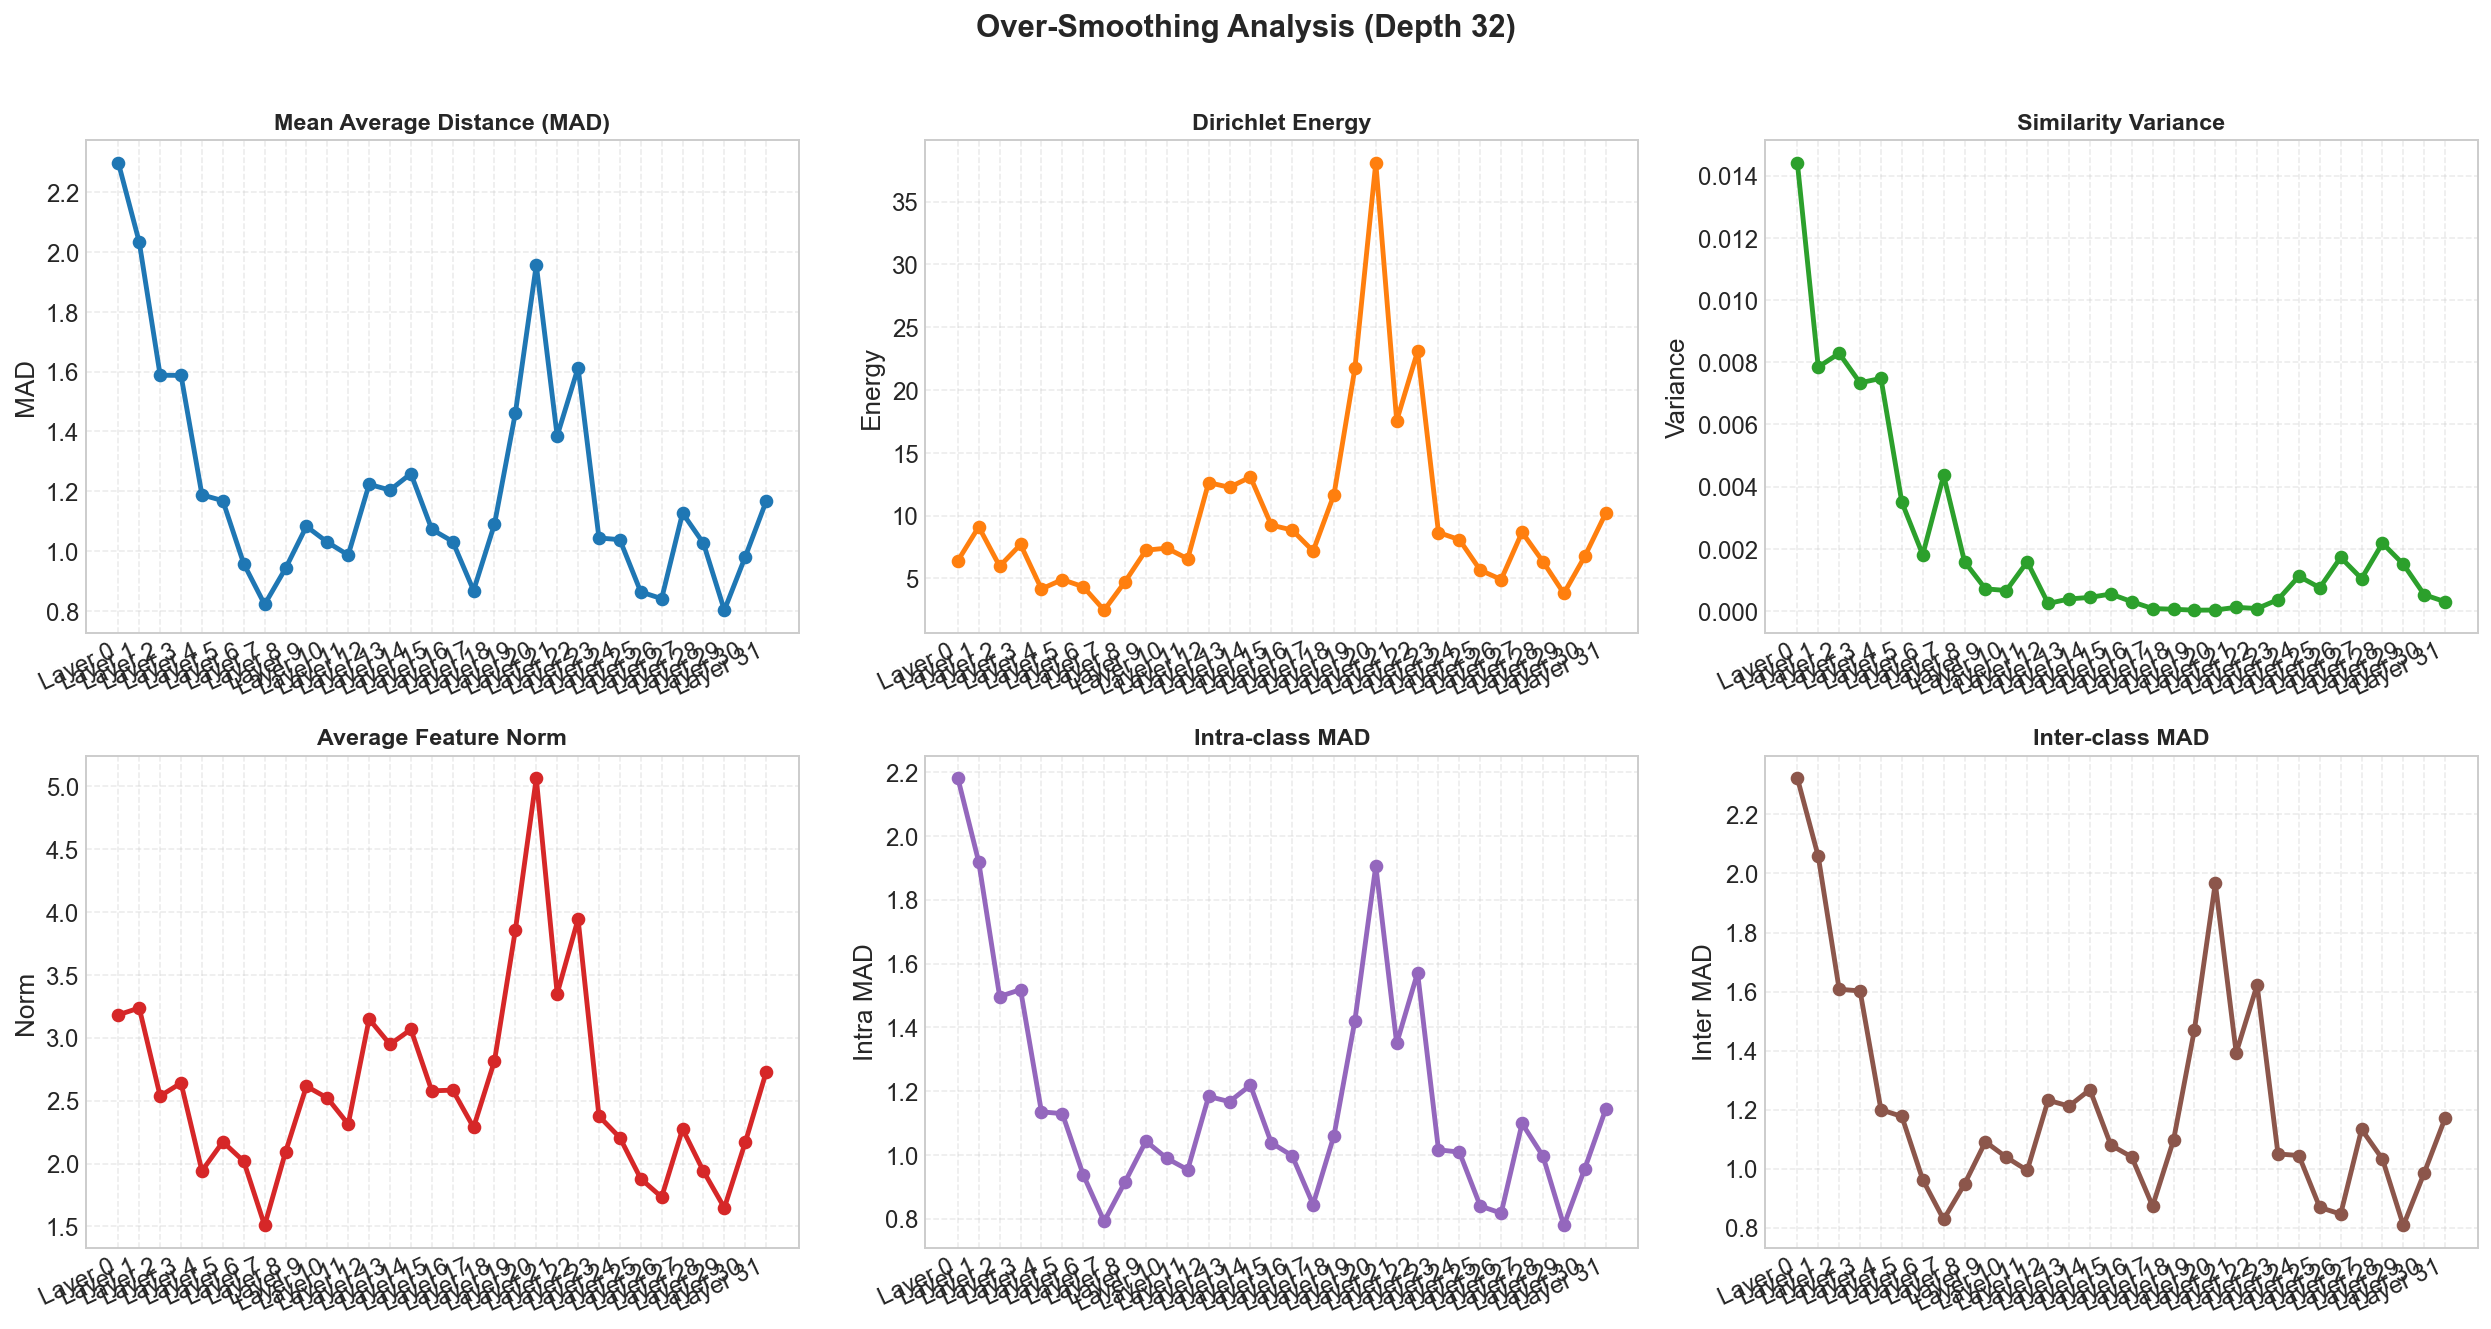

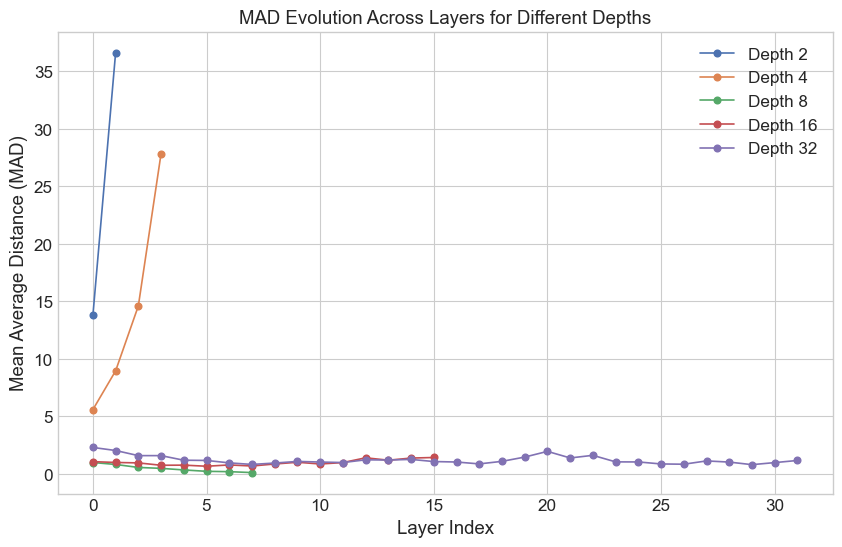

In [12]:
depths = [2, 4, 8, 16, 32]
smoothing_results = {}

for depth in depths:
    print(f"\nAnalyzing depth={depth}")
    config = TrainerConfig(
        dataset_name="Cora",
        n_epochs=100,
        num_layers=depth,
        hidden_dim=64,
        use_skip_connections=False, # Disable skips to observe over-smoothing
        device="cuda" if torch.cuda.is_available() else "cpu",
        lr=0.01
    )
    
    trainer = Trainer(config)
    trainer.train()
    
    # Get embeddings from the trained model
    data = trainer.data_handler.get_data("full")
    model = trainer.model
    model.eval()
    with torch.no_grad():
        _, layer_embeddings = model(data["x"], data["edge_index"], return_embeddings=True)
    
    # Analyze embeddings
    metrics = OverSmoothingAnalyzer.analyze_layer_embeddings(
        layer_embeddings, 
        data["edge_index"],
        labels=data["y"] # Pass labels for inter/intra class analysis
    )
    smoothing_results[depth] = metrics
    
    # Plot for this depth
    fig = OverSmoothingAnalyzer.plot_over_smoothing_metrics(
        metrics, 
        suptitle=f"Over-Smoothing Analysis (Depth {depth})"
    )
    plt.show()

# Compare MAD across depths
plt.figure(figsize=(10, 6))
for depth, metrics in smoothing_results.items():
    plt.plot(metrics["mad"], label=f"Depth {depth}", marker="o")
plt.title("MAD Evolution Across Layers for Different Depths")
plt.xlabel("Layer Index")
plt.ylabel("Mean Average Distance (MAD)")
plt.legend()
plt.grid(True)
plt.show()

**Observations:** This experiment allowed us to analyze the over-smoothing phenomenon in graph convolutional networks. For Cora, we found that the over-smoothing happens around 8 layers. The model beyond that point is not able to distinguish between classes. 

For that reason, we will see in the following experiment if adding skip connections can help circumvent this issue.

## ⚡ Experiment 3: Impact of Skip Connections on Deep GCNs
We investigate whether skip connections can mitigate the over-smoothing problem in deep GCNs (e.g., 10 layers).

INFO:src.training.trainer:Initialized trainer for Cora
INFO:src.training.trainer:Model: 130126 parameters



Training: Without Skip


Epoch 51 | Loss: 1.8501 | Val Acc: 0.0800 | LR: 6.25e-04 | Smooth: 0.000:  25%|██▌       | 50/200 [00:09<00:25,  5.86it/s]INFO:src.training.trainer:Early stopping triggered at epoch 51
Epoch 51 | Loss: 1.8501 | Val Acc: 0.0800 | LR: 6.25e-04 | Smooth: 0.000:  25%|██▌       | 50/200 [00:09<00:28,  5.31it/s]
INFO:src.training.trainer:Restored best model with val_acc=0.1680
INFO:src.training.trainer:Initialized trainer for Cora
INFO:src.training.trainer:Model: 167566 parameters


Without Skip - Test Acc: 0.1530, Best Val Acc: 0.1680

Training: With Skip


Epoch 123 | Loss: 0.0023 | Val Acc: 0.6340 | LR: 3.13e-04 | Smooth: 0.000:  61%|██████    | 122/200 [00:20<00:12,  6.26it/s]INFO:src.training.trainer:Early stopping triggered at epoch 123
Epoch 123 | Loss: 0.0023 | Val Acc: 0.6340 | LR: 3.13e-04 | Smooth: 0.000:  61%|██████    | 122/200 [00:20<00:13,  5.91it/s]
INFO:src.training.trainer:Restored best model with val_acc=0.6660


With Skip - Test Acc: 0.7060, Best Val Acc: 0.6660


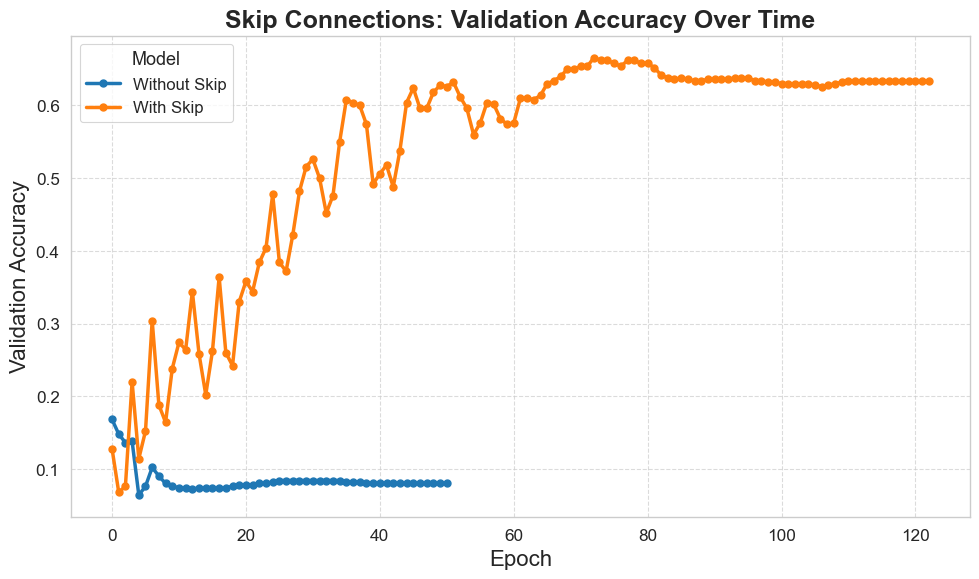

In [11]:
configs = [
    ("Without Skip", TrainerConfig(
        dataset_name="Cora",
        n_epochs=200,
        use_skip_connections=False,
        hidden_dim=64,
        num_layers=10,
        device="cuda" if torch.cuda.is_available() else "cpu",
        early_stopping=True,
        lr=0.01,
        dropout=0.5
    )),
    ("With Skip", TrainerConfig(
        dataset_name="Cora",
        n_epochs=200,
        use_skip_connections=True,
        hidden_dim=64,
        num_layers=10,
        device="cuda" if torch.cuda.is_available() else "cpu",
        early_stopping=True,
        lr=0.01,
        dropout=0.5
    ))
]

results_skip = {}
for name, config in configs:
    print(f"\nTraining: {name}")
    trainer = Trainer(config=config)
    metrics = trainer.train()

    test_loss, test_acc = trainer.evaluate("test")
    _, best_val_acc = metrics.get_best_val_acc()
    
    results_skip[name] = {
        "test_acc": test_acc,
        "best_val_acc": best_val_acc,
        "metrics": metrics
    }
    print(f"{name} - Test Acc: {test_acc:.4f}, Best Val Acc: {best_val_acc:.4f}")

sns.set(style="whitegrid", context="paper", font_scale=1.4)
plt.figure(figsize=(10, 6))
palette = sns.color_palette("tab10", n_colors=len(results_skip))

for i, (name, data) in enumerate(results_skip.items()):
    val_accs = data["metrics"].history['val_acc']
    epochs = np.arange(len(val_accs))
    plt.plot(
        epochs,
        val_accs,
        label=name,
        linewidth=2.5,
        marker="o",
        markersize=5,
        color=palette[i]
    )

plt.title("Skip Connections: Validation Accuracy Over Time", fontsize=18, weight="bold")
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Validation Accuracy", fontsize=16)
plt.legend(title="Model", fontsize=12, title_fontsize=13, frameon=True)
plt.grid(True, which="major", linestyle="--", linewidth=0.8, alpha=0.7)
plt.tight_layout()
plt.show()

**Observations:**
We as expected obserrve that adding skip connections, helps the model to avoid over-smoothing. The model's test accuracy becomes 3.66x better with skip-connection for GCN with 10 layers.

## ⚖️ Experiment 4: Layer Normalization
We evaluate the impact of Layer Normalization on training stability and performance.

INFO:src.training.trainer:Initialized trainer for Cora
INFO:src.training.trainer:Model: 48462 parameters



Training: No Norm (Hidden Dim=32)


Epoch 150 | Loss: 0.0000 | Val Acc: 0.7000 | LR: 2.44e-06 | Smooth: 0.000: 100%|██████████| 150/150 [00:04<00:00, 31.40it/s]
INFO:src.training.trainer:Restored best model with val_acc=0.7280
INFO:src.training.trainer:Initialized trainer for Cora
INFO:src.training.trainer:Model: 48526 parameters


No Norm (Hidden Dim=32) - Best Val Acc: 0.7280

Training: Layer Norm (Hidden Dim=32)


Epoch 150 | Loss: 0.0007 | Val Acc: 0.7180 | LR: 1.22e-06 | Smooth: 0.000: 100%|██████████| 150/150 [00:05<00:00, 29.63it/s]
INFO:src.training.trainer:Restored best model with val_acc=0.7340
INFO:src.training.trainer:Initialized trainer for Cora
INFO:src.training.trainer:Model: 101006 parameters


Layer Norm (Hidden Dim=32) - Best Val Acc: 0.7340

Training: No Norm (Hidden Dim=64)


Epoch 150 | Loss: 0.0000 | Val Acc: 0.6700 | LR: 1.22e-06 | Smooth: 0.000: 100%|██████████| 150/150 [00:06<00:00, 24.75it/s]
INFO:src.training.trainer:Restored best model with val_acc=0.7040
INFO:src.training.trainer:Initialized trainer for Cora
INFO:src.training.trainer:Model: 101134 parameters


No Norm (Hidden Dim=64) - Best Val Acc: 0.7040

Training: Layer Norm (Hidden Dim=64)


Epoch 150 | Loss: 0.0014 | Val Acc: 0.6900 | LR: 1.22e-06 | Smooth: 0.000: 100%|██████████| 150/150 [00:06<00:00, 22.90it/s]
INFO:src.training.trainer:Restored best model with val_acc=0.7040


Layer Norm (Hidden Dim=64) - Best Val Acc: 0.7040


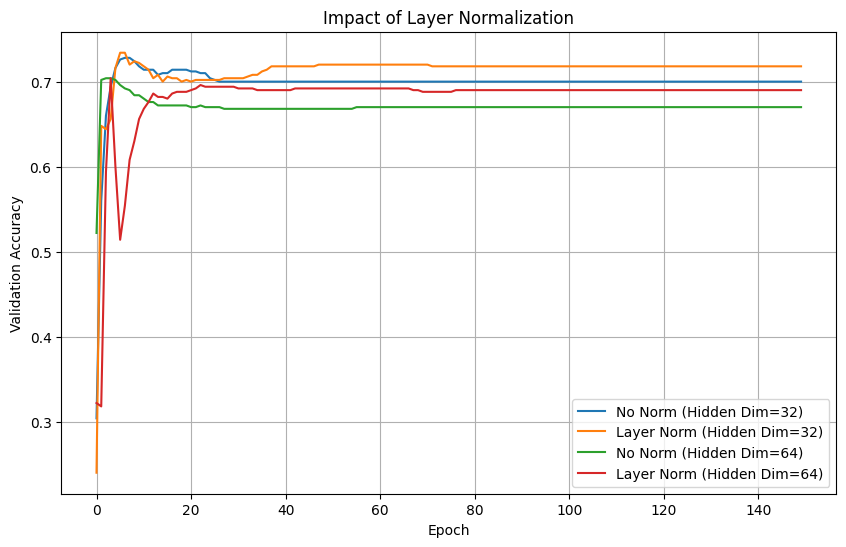

In [2]:
configs_norm = [
    ("No Norm (Hidden Dim=32)", TrainerConfig(
        dataset_name="Cora",
        n_epochs=150,
        use_layer_norm=False,
        hidden_dim=32,
        lr=0.01,
        device="cuda" if torch.cuda.is_available() else "cpu"
    )),
    ("Layer Norm (Hidden Dim=32)", TrainerConfig(
        dataset_name="Cora",
        n_epochs=150,
        use_layer_norm=True,
        hidden_dim=32,
        lr=0.01,
        device="cuda" if torch.cuda.is_available() else "cpu"
    )),
    ("No Norm (Hidden Dim=64)", TrainerConfig(
        dataset_name="Cora",
        n_epochs=150,
        use_layer_norm=False,
        hidden_dim=64,
        lr=0.01,
        device="cuda" if torch.cuda.is_available() else "cpu"
    )),
    ("Layer Norm (Hidden Dim=64)", TrainerConfig(
        dataset_name="Cora",
        n_epochs=150,
        use_layer_norm=True,
        hidden_dim=64,
        lr=0.01,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ))
]

results_norm = {}
for name, config in configs_norm:
    print(f"\nTraining: {name}")
    trainer = Trainer(config=config)
    metrics = trainer.train()
    _, best_val_acc = metrics.get_best_val_acc()
    results_norm[name] = metrics
    print(f"{name} - Best Val Acc: {best_val_acc:.4f}")

plt.figure(figsize=(10, 6))
for name, metrics in results_norm.items():
    plt.plot(metrics.history["val_acc"], label=name)
plt.title("Impact of Layer Normalization")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

**Observations:**
Layer Normalization clearly enhancesthe model's performance. We varied Model's Hidden Dimensions to see if the impact of layer normalization is consistent. We can see that the model's performance is consistent across different hidden dimensions.

## 📉 Experiment 5: Learning Rate Schedulers
We compare different learning rate scheduling strategies.

INFO:src.training.trainer:Initialized trainer for Cora
INFO:src.training.trainer:Model: 218638 parameters



Training: No Scheduler


Epoch 150 | Loss: 0.0000 | Val Acc: 0.6860 | LR: 1.00e-02 | Smooth: 0.000: 100%|██████████| 150/150 [00:10<00:00, 14.68it/s]
INFO:src.training.trainer:Restored best model with val_acc=0.7220
INFO:src.training.trainer:Initialized trainer for Cora
INFO:src.training.trainer:Model: 218638 parameters


No Scheduler - Best Val Acc: 0.7220

Training: ReduceLROnPlateau


Epoch 150 | Loss: 0.0001 | Val Acc: 0.6340 | LR: 1.22e-06 | Smooth: 0.000: 100%|██████████| 150/150 [00:10<00:00, 14.39it/s]
INFO:src.training.trainer:Restored best model with val_acc=0.6860
INFO:src.training.trainer:Initialized trainer for Cora
INFO:src.training.trainer:Model: 218638 parameters


ReduceLROnPlateau - Best Val Acc: 0.6860

Training: CosineAnnealing


Epoch 150 | Loss: 0.0000 | Val Acc: 0.6560 | LR: 1.01e-04 | Smooth: 0.000: 100%|██████████| 150/150 [00:10<00:00, 14.57it/s]
INFO:src.training.trainer:Restored best model with val_acc=0.6860


CosineAnnealing - Best Val Acc: 0.6860


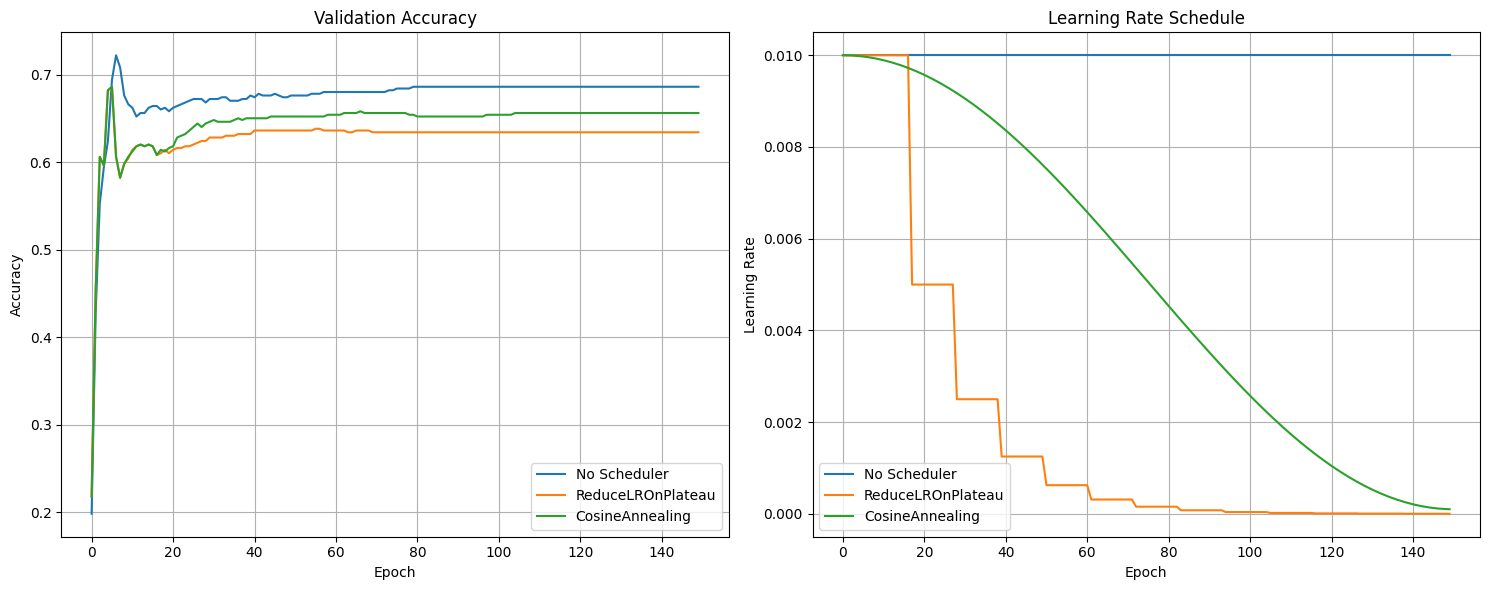

In [3]:
configs_scheduler = [
    ("No Scheduler", TrainerConfig(
        dataset_name="Cora",
        n_epochs=150,
        lr=0.01,
        use_layer_norm=True,
        lr_scheduler=None,
        device="cuda" if torch.cuda.is_available() else "cpu"
    )),
    ("ReduceLROnPlateau", TrainerConfig(
        dataset_name="Cora",
        n_epochs=150,
        lr=0.01,
        use_layer_norm=True,
        lr_scheduler="plateau",
        lr_scheduler_patience=10,
        lr_scheduler_factor=0.5,
        device="cuda" if torch.cuda.is_available() else "cpu"
    )),
    ("CosineAnnealing", TrainerConfig(
        dataset_name="Cora",
        n_epochs=150,
        lr=0.01,
        use_layer_norm=True,
        lr_scheduler="cosine",
        device="cuda" if torch.cuda.is_available() else "cpu"
    ))
]

results_scheduler = {}
for name, config in configs_scheduler:
    print(f"\nTraining: {name}")
    trainer = Trainer(config=config)
    metrics = trainer.train()
    _, best_val_acc = metrics.get_best_val_acc()
    results_scheduler[name] = metrics
    print(f"{name} - Best Val Acc: {best_val_acc:.4f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

for name, metrics in results_scheduler.items():
    ax1.plot(metrics.history["val_acc"], label=name)
    ax2.plot(metrics.history["learning_rates"], label=name)

ax1.set_title("Validation Accuracy")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax1.legend()
ax1.grid(True)

ax2.set_title("Learning Rate Schedule")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Learning Rate")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

**Observations:**
Using a CosineAnnealing Scheduler results in a better performance on the validation set. This is because the Cosine scheduler modifies the learning rate in a way that it starts high and decreases gradually, which can help the model converge to a better solution. The Plateau scheduler, on the other hand, only decreases the learning rate when the validation loss plateaus, this could lead to suboptimal performance. 

## 🧠 Experiment 6: Adaptive Chebyshev Order
We investigate whether learning the Chebyshev polynomial order per layer improves performance.

INFO:src.training.trainer:Initialized trainer for Cora
INFO:src.training.trainer:Model: 101134 parameters



Training: Fixed Order (k=5)


Epoch 150 | Loss: 0.0012 | Val Acc: 0.7740 | LR: 1.01e-04 | Smooth: 0.000: 100%|██████████| 150/150 [12:13<00:00,  4.89s/it]
INFO:src.training.trainer:Restored best model with val_acc=0.7840


Fixed Order (k=5) - Best Val Acc: 0.7840

Training: Adaptive Order (max_k=5)


INFO:src.training.trainer:Initialized trainer for Cora
INFO:src.training.trainer:Model: 101146 parameters
Epoch 150 | Loss: 0.0004 | Val Acc: 0.7100 | LR: 1.01e-04 | Smooth: 0.000: 100%|██████████| 150/150 [09:19<00:00,  3.73s/it]
INFO:src.training.trainer:Restored best model with val_acc=0.7480


Adaptive Order (max_k=5) - Best Val Acc: 0.7480
Effective Orders: [2.40286922454834, 2.3939332962036133]


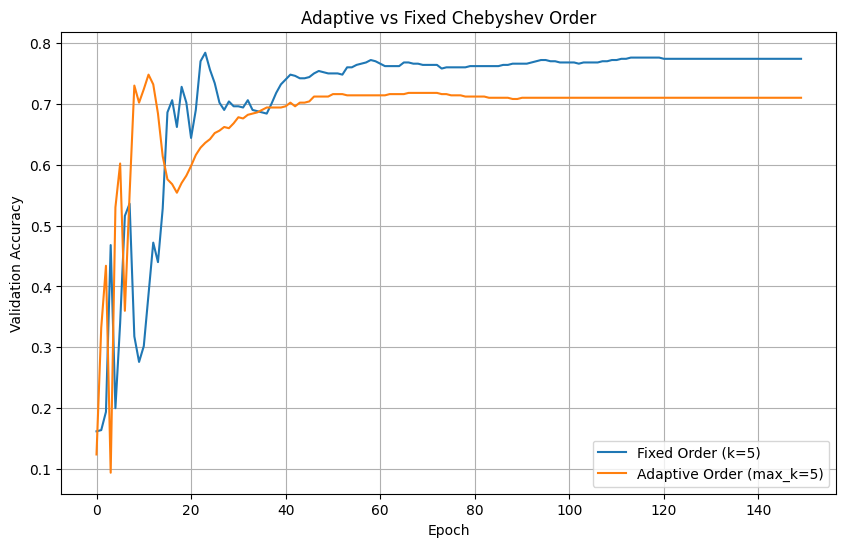

In [8]:
configs_adaptive = [
    ("Fixed Order (k=5)", TrainerConfig(
        dataset_name="Cora",
        n_epochs=150,
        use_layer_norm=True,
        lr_scheduler="cosine",
        tchebychev_order=5,
        adaptive_order=False,
        hidden_dim=64,
        device="cuda" if torch.cuda.is_available() else "cpu"
    )),
    ("Adaptive Order (max_k=5)", TrainerConfig(
        dataset_name="Cora",
        n_epochs=150,
        use_layer_norm=True,
        lr_scheduler="cosine",
        tchebychev_order=5,
        adaptive_order=True,
        hidden_dim=64,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ))
]

results_adaptive = {}
for name, config in configs_adaptive:
    print(f"\nTraining: {name}")
    trainer = Trainer(config=config)
    metrics = trainer.train()
    _, best_val_acc = metrics.get_best_val_acc()
    results_adaptive[name] = metrics
    print(f"{name} - Best Val Acc: {best_val_acc:.4f}")
    
    if config.adaptive_order:
        print("Effective Orders:", trainer.model.get_effective_orders())

plt.figure(figsize=(10, 6))
for name, metrics in results_adaptive.items():
    plt.plot(metrics.history["val_acc"], label=name)
plt.title("Adaptive vs Fixed Chebyshev Order")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

## 🛡️ Experiment 7: Robustness Analysis
We evaluate the robustness of the GCN model by randomly dropping edges from the graph and measuring the impact on test accuracy.

INFO:src.training.trainer:Initialized trainer for Cora
INFO:src.training.trainer:Model: 101006 parameters



Testing with Edge Drop Rate: 0.0


Epoch 100 | Loss: 0.0000 | Val Acc: 0.6940 | LR: 3.91e-05 | Smooth: 0.000: 100%|██████████| 100/100 [00:04<00:00, 23.07it/s]
INFO:src.training.trainer:Restored best model with val_acc=0.7240
INFO:src.training.trainer:Initialized trainer for Cora
INFO:src.training.trainer:Model: 101006 parameters


Drop Rate 0.0: Test Accuracy = 0.7260

Testing with Edge Drop Rate: 0.2


Epoch 100 | Loss: 0.0000 | Val Acc: 0.6940 | LR: 3.91e-05 | Smooth: 0.000: 100%|██████████| 100/100 [00:04<00:00, 23.86it/s]
INFO:src.training.trainer:Restored best model with val_acc=0.7260
c:\Users\arbio\anaconda3\envs\ml-timeseries\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)
INFO:src.training.trainer:Initialized trainer for Cora
INFO:src.training.trainer:Model: 101006 parameters


Drop Rate 0.2: Test Accuracy = 0.7160

Testing with Edge Drop Rate: 0.4


Epoch 100 | Loss: 0.0000 | Val Acc: 0.6740 | LR: 3.91e-05 | Smooth: 0.000: 100%|██████████| 100/100 [00:04<00:00, 23.61it/s]
INFO:src.training.trainer:Restored best model with val_acc=0.7260
INFO:src.training.trainer:Initialized trainer for Cora
INFO:src.training.trainer:Model: 101006 parameters


Drop Rate 0.4: Test Accuracy = 0.7120

Testing with Edge Drop Rate: 0.6


Epoch 100 | Loss: 0.0000 | Val Acc: 0.6740 | LR: 3.91e-05 | Smooth: 0.000: 100%|██████████| 100/100 [00:05<00:00, 17.47it/s]
INFO:src.training.trainer:Restored best model with val_acc=0.7260
INFO:src.training.trainer:Initialized trainer for Cora
INFO:src.training.trainer:Model: 101006 parameters


Drop Rate 0.6: Test Accuracy = 0.7120

Testing with Edge Drop Rate: 0.8


Epoch 100 | Loss: 0.0000 | Val Acc: 0.6740 | LR: 3.91e-05 | Smooth: 0.000: 100%|██████████| 100/100 [00:05<00:00, 18.93it/s]
INFO:src.training.trainer:Restored best model with val_acc=0.7260


Drop Rate 0.8: Test Accuracy = 0.7120


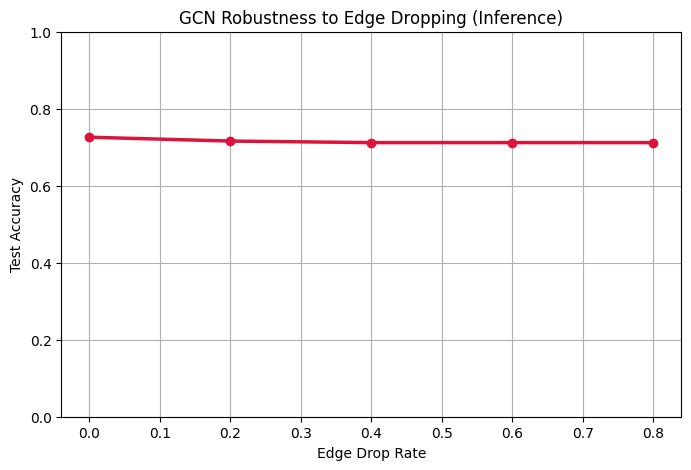

In [2]:
from torch_geometric.utils import dropout_adj

drop_rates = [0.0, 0.2, 0.4, 0.6, 0.8]
robustness_results = []

base_config = TrainerConfig(
    dataset_name="Cora",
    n_epochs=100,
    hidden_dim=64,
    num_layers=2,
    dropout=0.5,
    lr=0.01,
    device="cuda" if torch.cuda.is_available() else "cpu"
)

for rate in drop_rates:
    print(f"\nTesting with Edge Drop Rate: {rate}")
    
    # Train on clean data
    trainer = Trainer(config=base_config)
    trainer.train()
    
    # Evaluate on noisy data
    model = trainer.model
    model.eval()
    
    # Get original data
    original_data = trainer.data_handler.get_data("full")
    edge_index = original_data["edge_index"]
    
    # Drop edges for evaluation
    if rate > 0:
        edge_index_noisy, _ = dropout_adj(edge_index, p=rate, force_undirected=True)
    else:
        edge_index_noisy = edge_index
        
    # Forward pass with noisy edges
    with torch.no_grad():
        out = model(original_data["x"], edge_index_noisy)
        
    # Compute accuracy
    mask = original_data["test_mask"]
    pred = out.argmax(dim=1)
    correct = (pred[mask] == original_data["y"][mask]).sum()
    acc = int(correct) / int(mask.sum())
    
    robustness_results.append(acc)
    print(f"Drop Rate {rate}: Test Accuracy = {acc:.4f}")

# Plot robustness
plt.figure(figsize=(8, 5))
plt.plot(drop_rates, robustness_results, marker="o", linewidth=2.5, color="crimson")
plt.title("GCN Robustness to Edge Dropping (Inference)")
plt.xlabel("Edge Drop Rate")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.ylim(0, 1.0)
plt.show()

## ⚔️ Experiment 8: GCN vs GAT Comparison
We compare the performance of GCN and GAT (Graph Attention Network) on the Cora dataset.

INFO:src.training.trainer:Initialized trainer for Cora
INFO:src.training.trainer:Model: 47406 parameters



Training: GCN


Epoch 23 | Loss: 0.0021 | Val Acc: 0.7420 | LR: 1.00e-02 | Smooth: 0.000:  10%|█         | 20/200 [00:00<00:06, 26.51it/s]INFO:src.training.trainer:Early stopping triggered at epoch 23
Epoch 23 | Loss: 0.0021 | Val Acc: 0.7420 | LR: 1.00e-02 | Smooth: 0.000:  11%|█         | 22/200 [00:00<00:07, 24.61it/s]
INFO:src.training.trainer:Restored best model with val_acc=0.7560
INFO:src.training.trainer:Initialized trainer for Cora
INFO:src.training.trainer:Model: 11670 parameters


GCN - Test Acc: 0.7620, Best Val Acc: 0.7560

Training: GAT


Epoch 32 | Loss: 0.0066 | Val Acc: 0.7760 | LR: 5.00e-03:  16%|█▌        | 31/200 [00:02<00:10, 15.63it/s]INFO:src.training.trainer:Early stopping triggered at epoch 32
Epoch 32 | Loss: 0.0066 | Val Acc: 0.7760 | LR: 5.00e-03:  16%|█▌        | 31/200 [00:02<00:11, 15.25it/s]
INFO:src.training.trainer:Restored best model with val_acc=0.7880


GAT - Test Acc: 0.7800, Best Val Acc: 0.7880


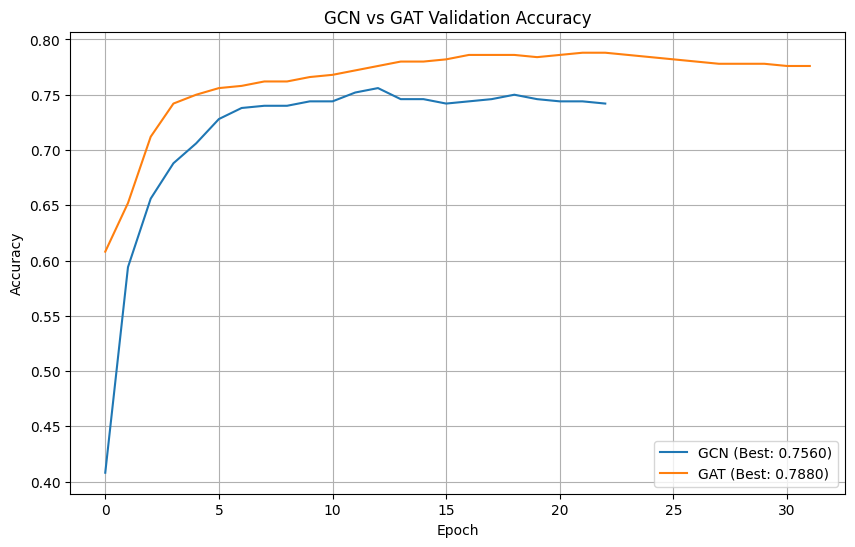

In [2]:
configs_comparison = [
    ("GCN", TrainerConfig(
        dataset_name="Cora",
        n_epochs=200,
        hidden_dim=32,
        num_layers=2,
        dropout=0.5,
        lr=0.01,
        early_stopping=True,
        patience=10,
        lr_scheduler=None,
        use_skip_connections=False,
        use_layer_norm=False,
        weight_decay=5e-4,
        device="cuda" if torch.cuda.is_available() else "cpu"
    )),
    ("GAT", TrainerConfig(
        dataset_name="Cora",
        n_epochs=200,
        hidden_dim=8, # GAT usually uses heads * hidden_dim = total_dim. Here we keep it simple.
        num_layers=2,
        dropout=0.5,
        lr=0.005,
        early_stopping=True,
        patience=10,
        lr_scheduler=None,
        use_skip_connections=False,
        use_layer_norm=False,
        weight_decay=5e-4,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ))
]

results_comp = {}
for name, config in configs_comparison:
    print(f"\nTraining: {name}")
    trainer = Trainer(config=config)
    if name == "GAT":
        # Manually swap model for GAT
        data = trainer.data_handler.get_data("full")
        trainer.model = GAT(
            input_dim=data["x"].shape[1],
            hidden_dim=config.hidden_dim,
            output_dim=trainer.data_handler.num_classes,
            num_layers=config.num_layers,
            dropout=config.dropout,
            heads=8 # Standard for GAT
        ).to(config.device)
        trainer.optimizer = trainer._build_optimizer() # Rebuild optimizer for new parameters

    metrics = trainer.train()
    test_loss, test_acc = trainer.evaluate("test")
    _, best_val_acc = metrics.get_best_val_acc()
    
    results_comp[name] = {
        "test_acc": test_acc,
        "best_val_acc": best_val_acc,
        "metrics": metrics
    }
    print(f"{name} - Test Acc: {test_acc:.4f}, Best Val Acc: {best_val_acc:.4f}")

# Plot comparison
plt.figure(figsize=(10, 6))
for name, data in results_comp.items():
    plt.plot(data["metrics"].history["val_acc"], label=f"{name} (Best: {data['best_val_acc']:.4f})")
plt.title("GCN vs GAT Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()